### Name: Keerthana Prakash

### USC ID: 2128268040

### Github Username: keerthana-prakash

In [1]:
import pandas as pd
import numpy as np 
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import cv2
from tensorflow.keras.applications import EfficientNetB0,VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Dense 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
sns.set_theme()
from keras.applications.vgg16 import preprocess_input

### 1. Transfer Learning for Image Classification

#### It is highly recommended that you complete this project using Keras and Python.

### (a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders.

### (b) Data Exploration and Pre-processing

#### i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.


In [2]:
df = pd.read_excel("../data/Classes.xlsx",names=['FolderName','Class'])
print("********************************* CLASSES FROM Classes.xlsx *********************************")
display(df)

one_hot_encoded_labels = pd.get_dummies(df,columns=['Class'])
print("********************************* ONE HOT ENCODED CLASS LABELS *********************************")
display(one_hot_encoded_labels)

********************************* CLASSES FROM Classes.xlsx *********************************


,FolderName,Class
0,005.Crested_Auklet,0
1,013.Bobolink,1
2,015.Lazuli_Bunting,2
3,023.Brandt_Cormorant,3
4,040.Olive_sided_Flycatcher,4
5,041.Scissor_tailed_Flycatcher,5
6,067.Anna_Hummingbird,6
7,072.Pomarine_Jaeger,7
8,076.Dark_eyed_Junco,8
9,081.Pied_Kingfisher,9


********************************* ONE HOT ENCODED CLASS LABELS *********************************


,FolderName,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,...,Class_10,Class_11,Class_12,Class_13,Class_14,Class_15,Class_16,Class_17,Class_18,Class_19
0,005.Crested_Auklet,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,013.Bobolink,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,015.Lazuli_Bunting,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,023.Brandt_Cormorant,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,040.Olive_sided_Flycatcher,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,041.Scissor_tailed_Flycatcher,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,067.Anna_Hummingbird,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,072.Pomarine_Jaeger,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,076.Dark_eyed_Junco,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,081.Pied_Kingfisher,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### ii. Randomly select 0.7ni images from each folder as your training set, 0.15ni as validation set, and the rest as your test set, where ni is the number of images in folder i and dxe is the ceiling of x.

In [3]:
img_path = '../data/images/'
image_path_to_labels = dict()
total_X_train = pd.DataFrame()
total_X_validation = pd.DataFrame()
total_X_test = pd.DataFrame()
for label in df[df.columns[0]]:
    images = []
    
    for img_file in os.listdir(img_path+label):
        images.append([img_path+label+'/'+img_file,label])
    
    images = pd.DataFrame(images,columns=['Path','FolderName'])

    X_train, X_rem = train_test_split(images, train_size=0.7)
    X_valid, X_test = train_test_split(X_rem, test_size=0.5)

    total_X_train = pd.concat([total_X_train,X_train],axis=0,ignore_index=True)
    total_X_validation = pd.concat([total_X_validation,X_valid],axis=0,ignore_index=True)
    total_X_test = pd.concat([total_X_test,X_test],axis=0,ignore_index=True)
    
    image_path_to_labels[label] = (X_train,X_valid,X_test)

total_X_train = pd.merge(total_X_train, one_hot_encoded_labels, on="FolderName", how="left")
total_X_validation = pd.merge(total_X_validation, one_hot_encoded_labels, on="FolderName", how="left")
total_X_test = pd.merge(total_X_test, one_hot_encoded_labels, on="FolderName", how="left")

print("********************************* TRAINING SET IMAGE PATHS WITH ENCODED LABELS *********************************")
display(total_X_train)
print("********************************* VALIDATION SET IMAGE PATHS WITH ENCODED LABELS *********************************")
display(total_X_validation)
print("********************************* TESTING SET IMAGE PATHS WITH ENCODED LABELS *********************************")
display(total_X_test)


********************************* TRAINING SET IMAGE PATHS WITH ENCODED LABELS *********************************


,Path,FolderName,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,...,Class_10,Class_11,Class_12,Class_13,Class_14,Class_15,Class_16,Class_17,Class_18,Class_19
0,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
816,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
817,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
818,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


********************************* VALIDATION SET IMAGE PATHS WITH ENCODED LABELS *********************************


,Path,FolderName,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,...,Class_10,Class_11,Class_12,Class_13,Class_14,Class_15,Class_16,Class_17,Class_18,Class_19
0,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
174,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
175,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


********************************* TESTING SET IMAGE PATHS WITH ENCODED LABELS *********************************


,Path,FolderName,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,...,Class_10,Class_11,Class_12,Class_13,Class_14,Class_15,Class_16,Class_17,Class_18,Class_19
0,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../data/images/005.Crested_Auklet/Crested_Aukl...,005.Crested_Auklet,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
174,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
175,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176,../data/images/168.Kentucky_Warbler/Kentucky_W...,168.Kentucky_Warbler,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [4]:
def read_and_scale_images(dataset):
    X = []
    y = []
    for i in range(len(dataset)):
        img = cv2.imread(str(dataset.loc[i,'Path']))
        resized_img = cv2.resize(img,(224,224))
        
        X.append(resized_img)
        y.append(dataset.loc[i,dataset.columns[2:]])
        
    X = np.array(X)
    y = np.array(y)
    
    return (X,y)
    

In [5]:
X_scaled_train,y_scaled_train = read_and_scale_images(total_X_train)
X_scaled_validation, y_scaled_validation = read_and_scale_images(total_X_validation)
X_scaled_test,y_scaled_test = read_and_scale_images(total_X_test)

### (c) Transfer Learning

#### i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

#### ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

#### iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

#### v. Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.


### Empirical Regularization

In [6]:
datagenTrain = ImageDataGenerator(
        rotation_range=30, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.3, # zoom
        horizontal_flip=True, # horizontal flip
        vertical_flip = True, # vertical flip
        brightness_range=[1.0,1.2]) # contrast

#### Example of empirical regularization on one of the training images: 

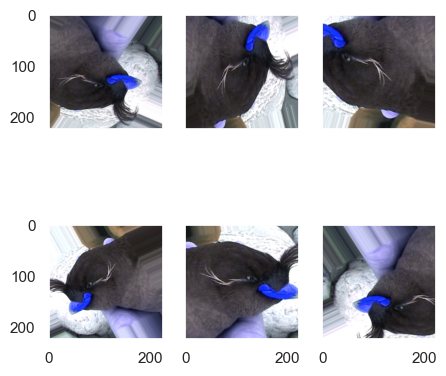

In [7]:
train_generator = datagenTrain.flow(np.expand_dims(X_scaled_train[0],0), batch_size=1)
rows = 2
columns = 3
fig, axes = plt.subplots(rows,columns,sharex=True, sharey=True, figsize=(5,5))
for r in range(rows):
    for c in range(columns):
        image_batch = train_generator.next()
        image = image_batch[0].astype('uint8')
        axes[r,c].imshow(image)
        axes[r,c].grid()
plt.show()

As we can see from the above plot, we have applied emperical regularization to training images and we can see the images are rotated, zoomed, flipped, cropped, contrasted etc. This is applied only to training data and not to validation or test set. 

In [8]:
##Applying preprocessing input of VGG16 to our dataset
X_scaled_train_vgg = preprocess_input(X_scaled_train)
X_scaled_validation_vgg = preprocess_input(X_scaled_validation)
X_scaled_test_vgg = preprocess_input(X_scaled_test)

In [9]:
IMG_SIZE = 224
NUM_CLASSES = 20
BATCH_SIZE=5
n_epochs = 100

In [10]:
def plot_training_vs_validation_metric(history, metric, typeOfGraph):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    if(typeOfGraph == 'error'):
        train_metrics = [1-x for x in train_metrics]
        val_metrics = [1-x for x in val_metrics]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ typeOfGraph)
    plt.xlabel("Epochs")
    plt.ylabel(typeOfGraph)
    plt.legend(["train_"+typeOfGraph, 'val_'+typeOfGraph])
    plt.show()
    
def get_one_hot_encoded_predictons(pred_prob):
    prediction_array = []
    for entry in pred_prob:
        prediction_array.append(np.argmax(entry))
    categ = to_categorical(prediction_array)
    return categ

def plot_confusion_matrix(confusion):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(confusion, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    
def build_confusionMatrix(cf):
    plt.figure(figsize=(10,10))
    sns.heatmap(cf, 
                annot=True, cmap='Blues', fmt='d', cbar_kws={'shrink': .5})
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)
    plt.show()
    return cf

def avg_train_validation(model_history):
    train_metrics = model_history.history['accuracy']
    val_metrics = model_history.history['val_accuracy']
    return ((sum(train_metrics) / len(train_metrics)),(sum(val_metrics) / len(val_metrics)))

def display_metrics(model,train_set, train_labels,validation_set,validation_labels, test_set, test_labels):
    y_test_pred = get_one_hot_encoded_predictons(model.predict(test_set))
    y_train_pred = get_one_hot_encoded_predictons(model.predict(train_set))
    y_validation_pred = get_one_hot_encoded_predictons(model.predict(validation_set))
            
    accuracy_train = accuracy_score(train_labels.astype('float32'),y_train_pred)
    accuracy_test = accuracy_score(test_labels.astype('float32'),y_test_pred)
    accuracy_validation = accuracy_score(validation_labels.astype('float32'),y_validation_pred)

    print("ACCURACY ON TRAIN: ",accuracy_train)
    print("ACCURACY ON VALIDATION: ",accuracy_validation)
    print("ACCURACY ON TEST: ",accuracy_test)

    print("CLASSIFICATION REPORT ON TRAIN")
    print(classification_report(train_labels.astype('float32'),y_train_pred))
            
    print("CLASSIFICATION REPORT ON VALIDATION")
    print(classification_report(validation_labels.astype('float32'),y_validation_pred))
               
    print("CLASSIFICATION REPORT ON TEST")
    print(classification_report(test_labels.astype('float32'),y_test_pred))
    
    print('CONFUSION MATRIX ON TRAIN DATASET \n')
    build_confusionMatrix(confusion_matrix(train_labels.astype('float32').argmax(axis=1), y_train_pred.argmax(axis=1)))

    print('CONFUSION MATRIX ON VALIDATION DATASET \n')
    build_confusionMatrix(confusion_matrix(validation_labels.astype('float32').argmax(axis=1), y_validation_pred.argmax(axis=1)))

    print('CONFUSION MATRIX ON TEST DATASET \n')
    build_confusionMatrix(confusion_matrix(test_labels.astype('float32').argmax(axis=1), y_test_pred.argmax(axis=1)))

    macro_precision_train_score = precision_score(train_labels.astype('float32'), y_train_pred, average='macro')
    macro_recall_train_score = recall_score(train_labels.astype('float32'), y_train_pred, average='macro')
    macro_f1_train_score = f1_score(train_labels.astype('float32'), y_train_pred, average='macro')
    
    macro_precision_test_score = precision_score(test_labels.astype('float32'), y_test_pred, average='macro')
    macro_recall_test_score = recall_score(test_labels.astype('float32'), y_test_pred, average='macro')
    macro_f1_test_score = f1_score(test_labels.astype('float32'), y_test_pred, average='macro')
            
    macro_precision_validation_score = precision_score(validation_labels.astype('float32'), y_validation_pred, average='macro')
    macro_recall_validation_score = recall_score(validation_labels.astype('float32'), y_validation_pred, average='macro')
    macro_f1_validation_score = f1_score(validation_labels.astype('float32'), y_validation_pred, average='macro')
    
    return [[accuracy_train,macro_precision_train_score,macro_recall_train_score,macro_f1_train_score],
            [accuracy_validation,macro_precision_validation_score,macro_recall_validation_score,macro_f1_validation_score],
            [accuracy_test,macro_precision_test_score,macro_recall_test_score,macro_f1_test_score]]


In [11]:
# ModelCheckpoint callback - save best weights
checkpoint_vgg16 = ModelCheckpoint(filepath='vgg16.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

checkpoint_efficientNet = ModelCheckpoint(filepath='efficient.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,mode='min')

In [12]:
def build_vgg16_model(num_classes):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    model = VGG16(include_top=False, input_shape=input_shape, weights="imagenet")
    # Freeze the pretrained weights
    for layer in model.layers:
        layer.trainable = False
   
    x = layers.Flatten()(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(2048, activation=tf.keras.activations.relu)(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output_layer = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs = model.input, outputs = output_layer,name='VGG16')
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


In [13]:
def build_effNet_model(num_classes):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    model = EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")
    # Freeze the pretrained weights
    for layer in model.layers:
        layer.trainable = False
   
    x = layers.Flatten()(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(2048, activation=tf.keras.activations.relu)(x)
#     x = layers.Dense(2048, activation=tf.keras.activations.relu)(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output_layer = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs = model.input, outputs = output_layer,name='EfficientNetB0')
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


### Transfer learning with VGG16 without Early Stopping

In [14]:
vgg16_model = build_vgg16_model(NUM_CLASSES)
vgg16_model.summary()

vgg16_history = vgg16_model.fit(datagenTrain.flow(X_scaled_train_vgg,y_scaled_train.astype('float32')),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=(X_scaled_validation_vgg,y_scaled_validation.astype('float32')),
                            verbose=1)

2022-12-11 11:13:42.965325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Epoch 33/100
26/26 [==============================] - 197s 8s/step - loss: 0.9133 - accuracy: 0.8512 - val_loss: 3.4283 - val_accuracy: 0.7528
Epoch 34/100
26/26 [==============================] - 197s 8s/step - loss: 1.0906 - accuracy: 0.8341 - val_loss: 3.1923 - val_accuracy: 0.7584
Epoch 35/100
26/26 [==============================] - 197s 8s/step - loss: 0.7315 - accuracy: 0.8720 - val_loss: 3.1492 - val_accuracy: 0.7584
Epoch 36/100
26/26 [==============================] - 199s 8s/step - loss: 0.8803 - accuracy: 0.8512 - val_loss: 3.4065 - val_accuracy: 0.7022
Epoch 37/100
26/26 [==============================] - 198s 8s/step - loss: 1.0297 - accuracy: 0.8378 - val_loss: 3.3439 - val_accuracy: 0.7303
Epoch 38/100
26/26 [==============================] - 200s 8s/step - loss: 0.9867 - accuracy: 0.8598 - val_loss: 3.4586 - val_accuracy: 0.7360
Epoch 39/100
26/26 [==============================] - 198s 8s/step - loss: 0.8792 - accuracy: 0.8622 - val_loss: 3.2558 - val_accuracy: 0.7809

The training accuracy in the last epoch is 83.78% and validation accuracy is 76.40%

Below are the results of performing transfer learnig with VGG16 without early stopping. I have plotted three graphs, 
a. Training Loss vs Validation Loss
b. Training Accuracy vs Validation Accuracy
c. Training Error vs Validation Error

Plot (c) depicts the plot that we want to analyse over the epochs, it can be seen that validation error started off to be lower than training error but then started to increase and varying about ov er 100 epochs. 

Below is also listed the classification report with precision, recall and F1 scores for training, validation and test data set. 
The classification report for training and validation will report the overfit values as this is the dataset over which the model was trained, and would not give us the true picture of how the model actually works. 
Hence looking at how it performs on test set gives us a good picture of how the model is working on unseen data, it can be seen that without early stopping for over 100 epochs, an accuracy of 0.685 (68.5%) is achieved. 

Confusion matrix are also plotted for all the three datasets.

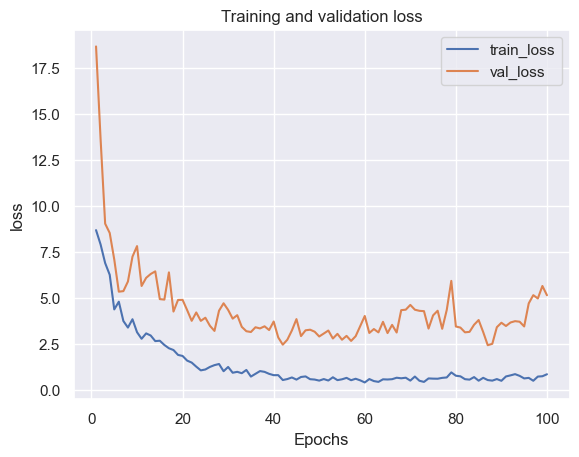

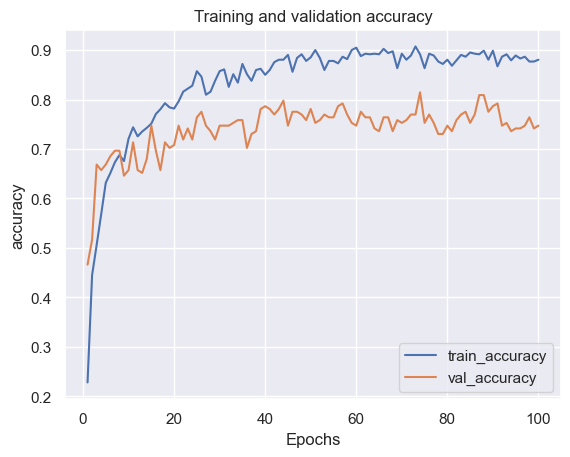

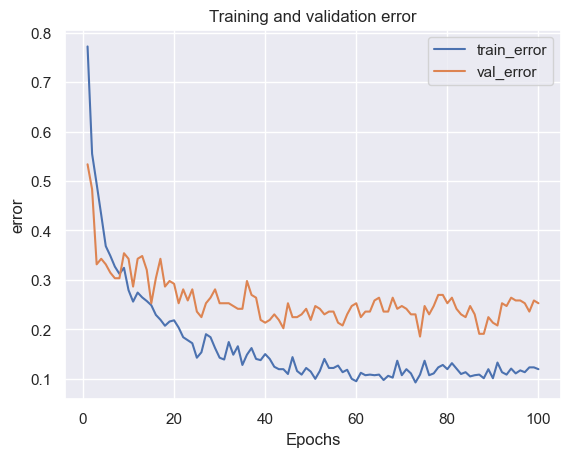

6/6 [==============================] - 34s 6s/step
ACCURACY ON TRAIN:  0.975609756097561
ACCURACY ON VALIDATION:  0.7471910112359551
ACCURACY ON TEST:  0.7303370786516854
CLASSIFICATION REPORT ON TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.98      0.99        42
           2       1.00      0.97      0.99        40
           3       0.98      0.98      0.98        41
           4       1.00      0.95      0.98        42
           5       1.00      1.00      1.00        42
           6       0.98      1.00      0.99        42
           7       1.00      0.98      0.99        42
           8       0.98      1.00      0.99        42
           9       1.00      1.00      1.00        42
          10       0.95      1.00      0.98        42
          11       0.98      1.00      0.99        42
          12       0.98      0.98      0.98        42
          13       0.93      0.98      0.

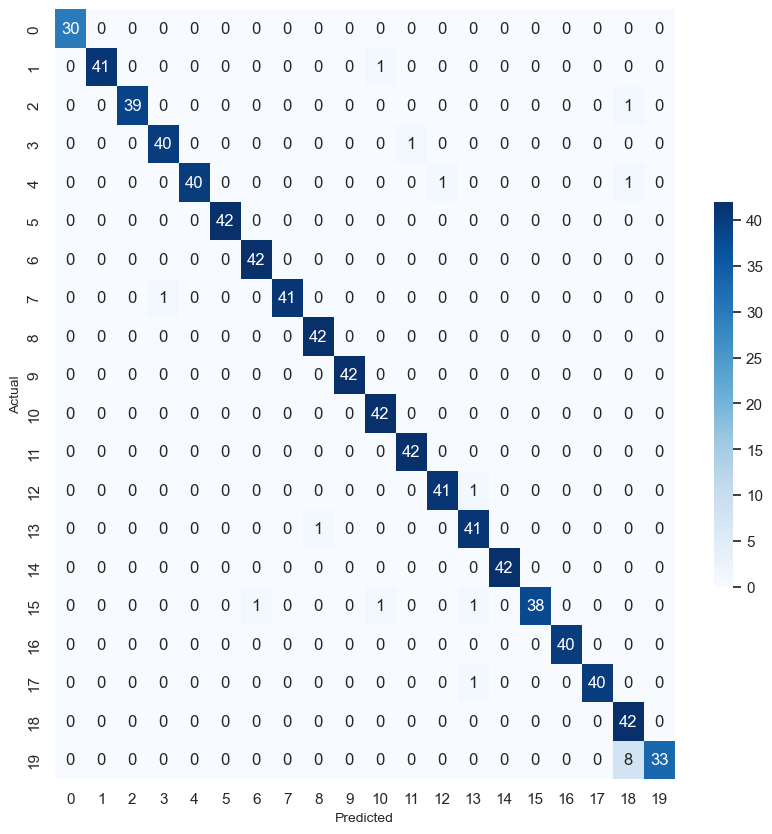

CONFUSION MATRIX ON VALIDATION DATASET 



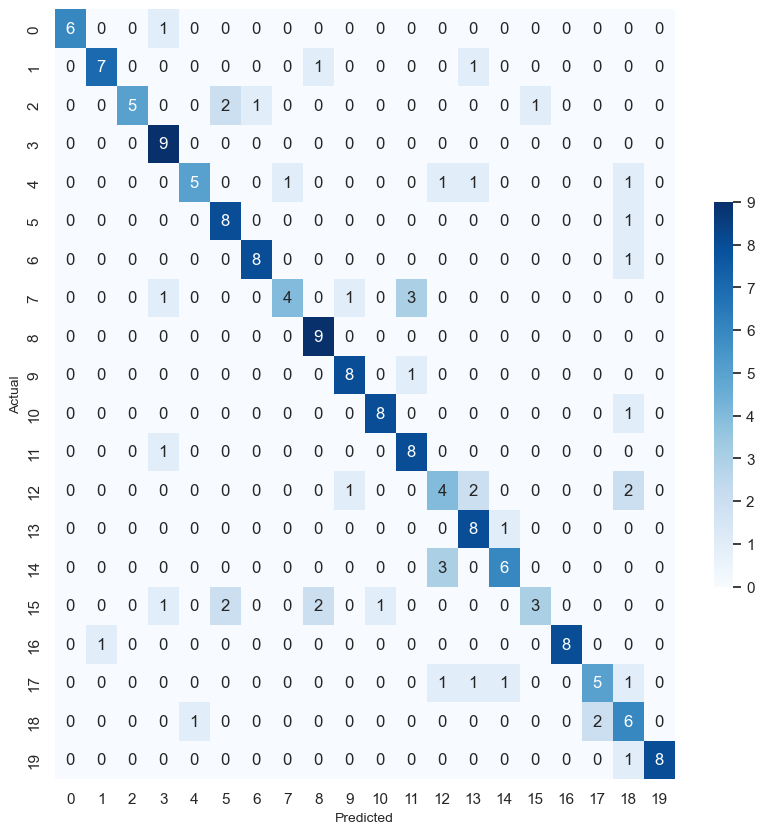

CONFUSION MATRIX ON TEST DATASET 



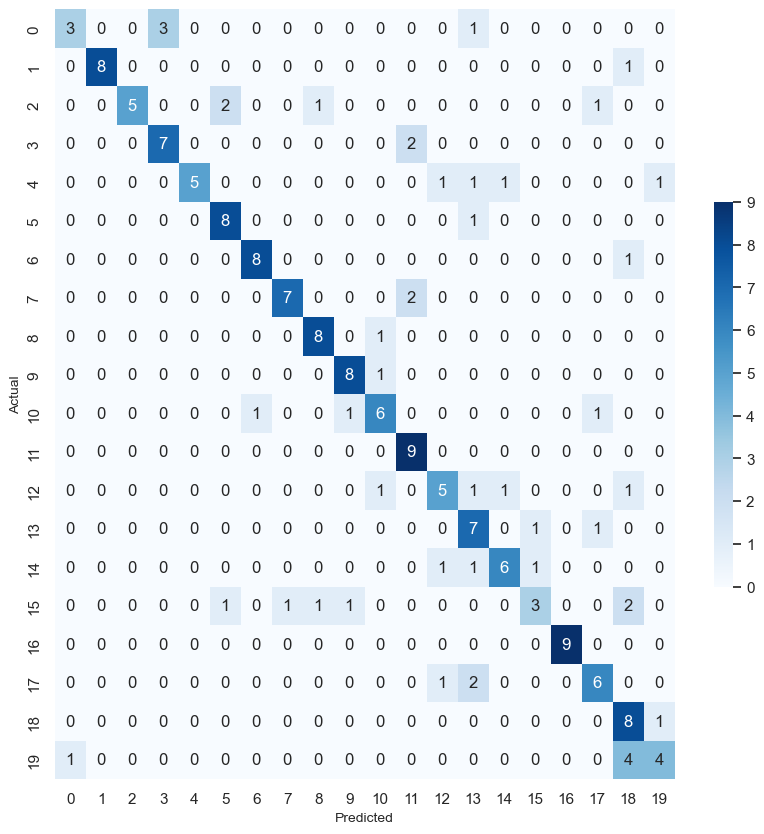

In [15]:
plot_training_vs_validation_metric(vgg16_history, 'loss','loss')
plot_training_vs_validation_metric(vgg16_history, 'accuracy','accuracy')
plot_training_vs_validation_metric(vgg16_history, 'accuracy','error')
vgg16_metrics = display_metrics(vgg16_model,X_scaled_train_vgg, y_scaled_train,X_scaled_validation_vgg, y_scaled_validation,X_scaled_test_vgg, y_scaled_test)

### Transfer learning with VGG16 with Early Stopping

In [16]:
vgg16_model_early_stopping = build_vgg16_model(NUM_CLASSES)
vgg16_model_early_stopping.summary()
vgg16_history_early_stopping = vgg16_model_early_stopping.fit(datagenTrain.flow(X_scaled_train_vgg,y_scaled_train.astype('float32')),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=(X_scaled_validation_vgg,y_scaled_validation.astype('float32')),
                            callbacks=[checkpoint_vgg16, early_stop],
                            verbose=1)
# hist = model.fit(x = X_scaled_train.astype('float32'),y = y_scaled_train.astype('float32'), validation_data = validation_data,verbose = 2, epochs = 50,batch_size=5)


Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

26/26 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.8805
Epoch 45: val_loss did not improve from 2.59014
26/26 [==============================] - 199s 8s/step - loss: 0.6976 - accuracy: 0.8805 - val_loss: 3.7300 - val_accuracy: 0.7640
Epoch 46/100
26/26 [==============================] - ETA: 0s - loss: 0.7685 - accuracy: 0.8512
Epoch 46: val_loss did not improve from 2.59014
26/26 [==============================] - 199s 8s/step - loss: 0.7685 - accuracy: 0.8512 - val_loss: 3.4910 - val_accuracy: 0.7472
Epoch 47/100
26/26 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.8866
Epoch 47: val_loss did not improve from 2.59014
26/26 [==============================] - 199s 8s/step - loss: 0.6044 - accuracy: 0.8866 - val_loss: 3.4699 - val_accuracy: 0.7753
Epoch 48/100
26/26 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.8890
Epoch 48: val_loss did not improve from 2.59014
26/26 [==============================] - 200s 8

Below are the results of performing transfer learnig with VGG16 with early stopping. I have plotted three graphs, 
a. Training Loss vs Validation Loss
b. Training Accuracy vs Validation Accuracy
c. Training Error vs Validation Error

Plot (c) depicts the plot that we want to analyse over the epochs, it can be seen that validation error started off to be lower than training error but then started to increase and varying about over 100 epochs. In order to avoid overfitting we have used early stopping with a patience level of 10, hence at the 28th epoch we could see that there was not significant improvement in the validation loss due which the training stopped. 

Below is also listed the classification report with precision, recall and F1 scores for training, validation and test data set. 
The classification report for training and validation will report the overfit values as this is the dataset over which the model was trained, and would not give us the true picture of how the model actually works. 
Hence looking at how it performs on test set gives us a good picture of how the model is working on unseen data, it can be seen that with early stopping , an accuracy of 0.6966 (68.5%) is achieved. 

Confusion matrix are also plotted for all the three datasets.

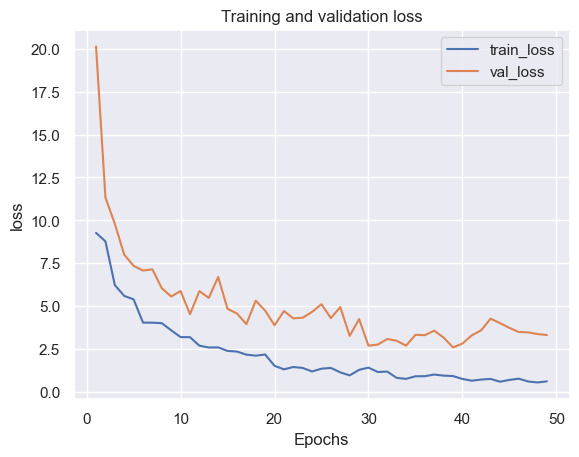

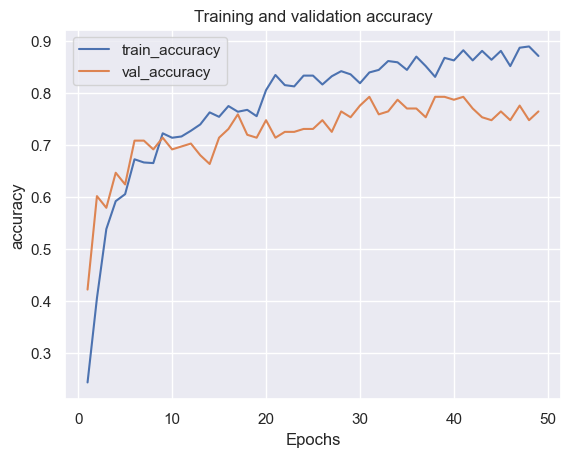

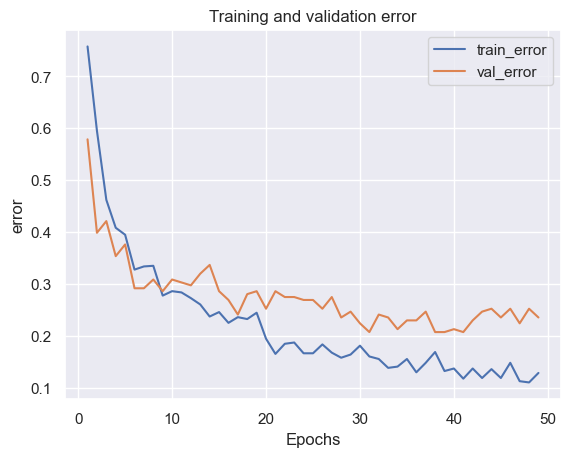

6/6 [==============================] - 35s 6s/step
ACCURACY ON TRAIN:  0.9719512195121951
ACCURACY ON VALIDATION:  0.7921348314606742
ACCURACY ON TEST:  0.7696629213483146
CLASSIFICATION REPORT ON TRAIN
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      0.98      0.99        42
           2       1.00      1.00      1.00        40
           3       0.85      1.00      0.92        41
           4       1.00      0.95      0.98        42
           5       1.00      0.95      0.98        42
           6       0.98      1.00      0.99        42
           7       1.00      0.90      0.95        42
           8       1.00      0.98      0.99        42
           9       1.00      1.00      1.00        42
          10       0.93      1.00      0.97        42
          11       1.00      0.95      0.98        42
          12       0.91      0.95      0.93        42
          13       0.93      0.98      0

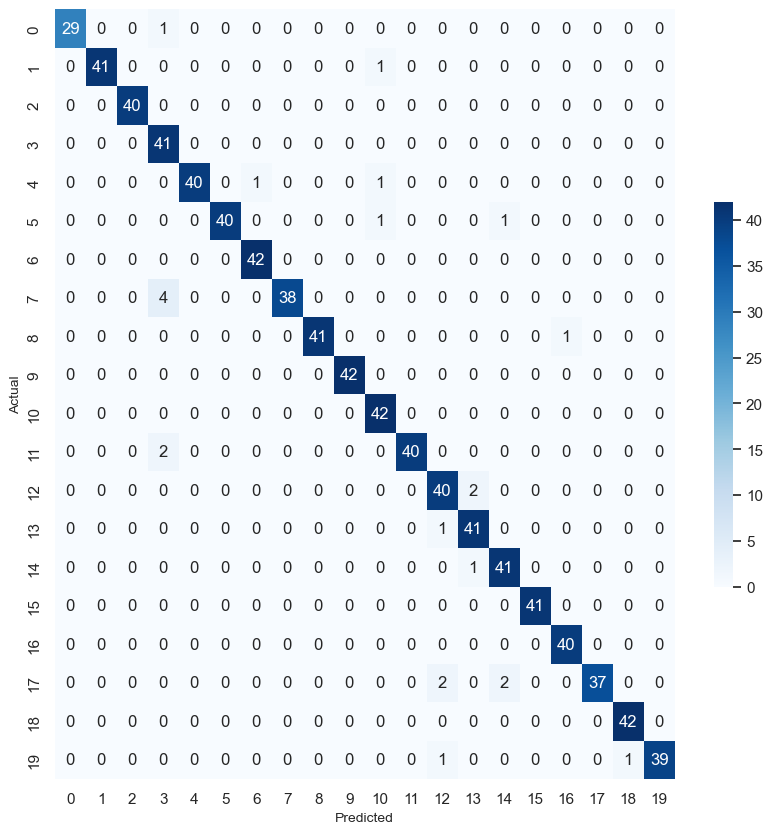

CONFUSION MATRIX ON VALIDATION DATASET 



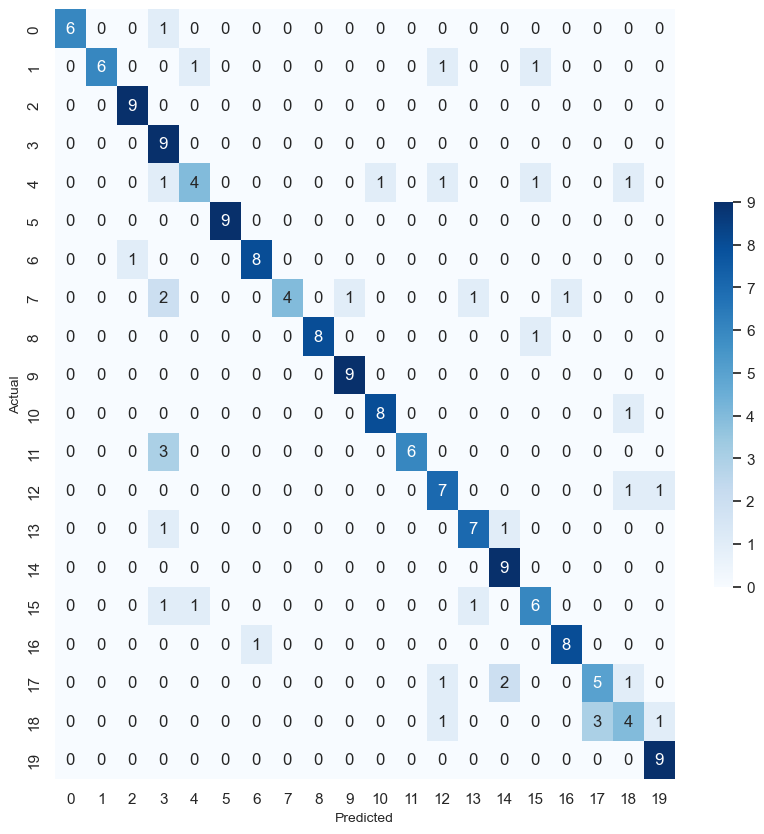

CONFUSION MATRIX ON TEST DATASET 



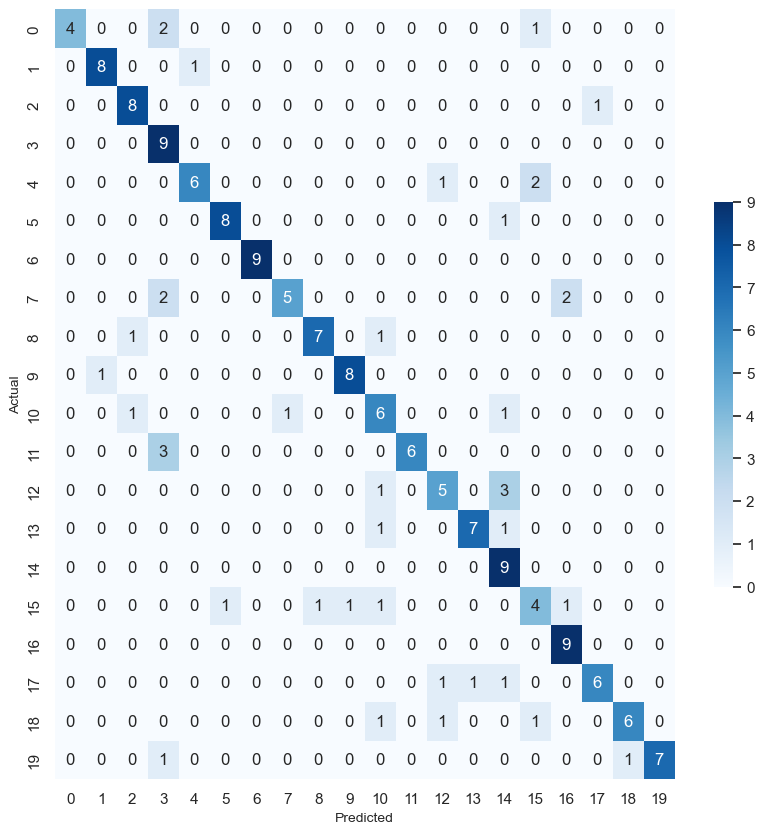

In [17]:
plot_training_vs_validation_metric(vgg16_history_early_stopping, 'loss','loss')
plot_training_vs_validation_metric(vgg16_history_early_stopping, 'accuracy','accuracy')
plot_training_vs_validation_metric(vgg16_history_early_stopping, 'accuracy','error')
vgg16_early_stopping_metrics = display_metrics(vgg16_model_early_stopping,X_scaled_train_vgg, y_scaled_train, X_scaled_validation_vgg, y_scaled_validation,X_scaled_test_vgg, y_scaled_test)


### Transfer learning with EfficientNetB0 without Early Stopping

In [18]:
effnet_model = build_effNet_model(NUM_CLASSES)
effnet_model.summary()
effnet_history = effnet_model.fit(datagenTrain.flow(X_scaled_train,y_scaled_train.astype('float32')),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=(X_scaled_validation,y_scaled_validation.astype('float32')),
                            verbose=1)

Model: "EfficientNetB0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

Epoch 77/100
26/26 [==============================] - 43s 2s/step - loss: 0.7183 - accuracy: 0.9110 - val_loss: 2.3540 - val_accuracy: 0.8146
Epoch 78/100
26/26 [==============================] - 50s 2s/step - loss: 0.8136 - accuracy: 0.9085 - val_loss: 2.1551 - val_accuracy: 0.8202
Epoch 79/100
26/26 [==============================] - 41s 2s/step - loss: 0.4761 - accuracy: 0.9439 - val_loss: 2.6093 - val_accuracy: 0.8202
Epoch 80/100
26/26 [==============================] - 45s 2s/step - loss: 0.5785 - accuracy: 0.9366 - val_loss: 2.9537 - val_accuracy: 0.8034
Epoch 81/100
26/26 [==============================] - 48s 2s/step - loss: 0.5240 - accuracy: 0.9268 - val_loss: 2.4565 - val_accuracy: 0.8202
Epoch 82/100
26/26 [==============================] - 47s 2s/step - loss: 0.4339 - accuracy: 0.9439 - val_loss: 2.1136 - val_accuracy: 0.8034
Epoch 83/100
26/26 [==============================] - 41s 2s/step - loss: 0.7789 - accuracy: 0.9110 - val_loss: 2.1231 - val_accuracy: 0.7978
Epoch 

Below are the results of performing transfer learnig with EfficientNetB0 without early stopping. I have plotted three graphs, 
a. Training Loss vs Validation Loss
b. Training Accuracy vs Validation Accuracy
c. Training Error vs Validation Error

Plot (c) depicts the plot that we want to analyse over the epochs, it can be seen that validation error started off to be lower than training error but then started to increase and varying about over 100 epochs. 

Below is also listed the classification report with precision, recall and F1 scores for training, validation and test data set. 
The classification report for training and validation will report the overfit values as this is the dataset over which the model was trained, and would not give us the true picture of how the model actually works. 
Hence looking at how it performs on test set gives us a good picture of how the model is working on unseen data, it can be seen that without early stopping for over 100 epochs, an accuracy of 0.853 (85.3%) is achieved. 

Confusion matrix are also plotted for all the three datasets.

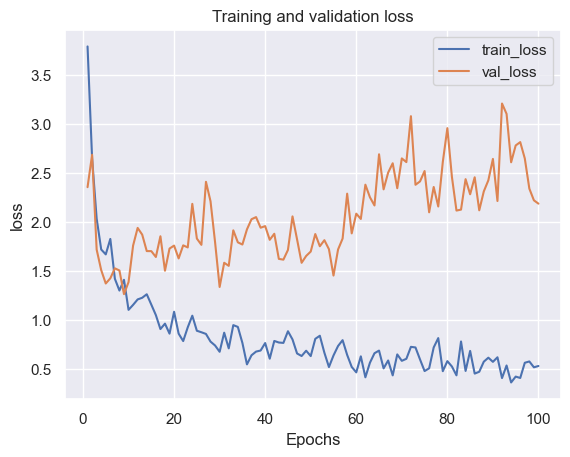

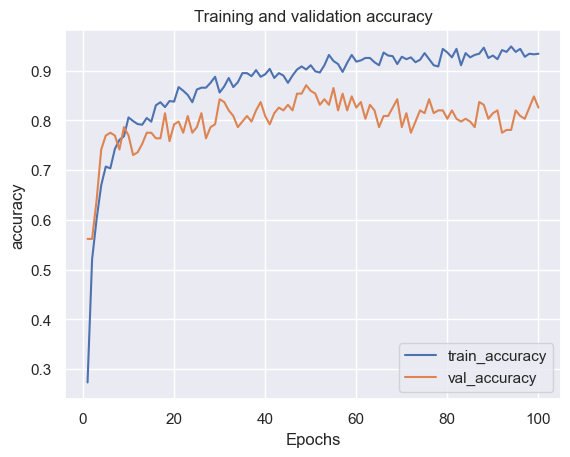

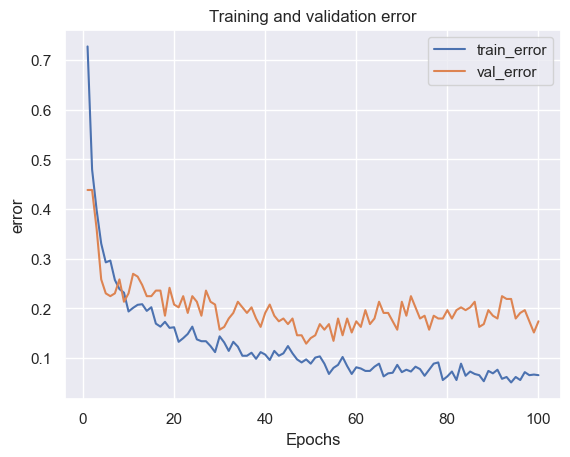

6/6 [==============================] - 4s 637ms/step
ACCURACY ON TRAIN:  0.9792682926829268
ACCURACY ON VALIDATION:  0.8258426966292135
ACCURACY ON TEST:  0.8033707865168539
CLASSIFICATION REPORT ON TRAIN
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.98      1.00      0.99        42
           2       0.95      1.00      0.98        40
           3       1.00      1.00      1.00        41
           4       0.98      0.95      0.96        42
           5       0.91      0.98      0.94        42
           6       0.98      1.00      0.99        42
           7       1.00      1.00      1.00        42
           8       1.00      1.00      1.00        42
           9       1.00      1.00      1.00        42
          10       1.00      0.98      0.99        42
          11       0.98      1.00      0.99        42
          12       0.95      1.00      0.98        42
          13       0.98      0.95     

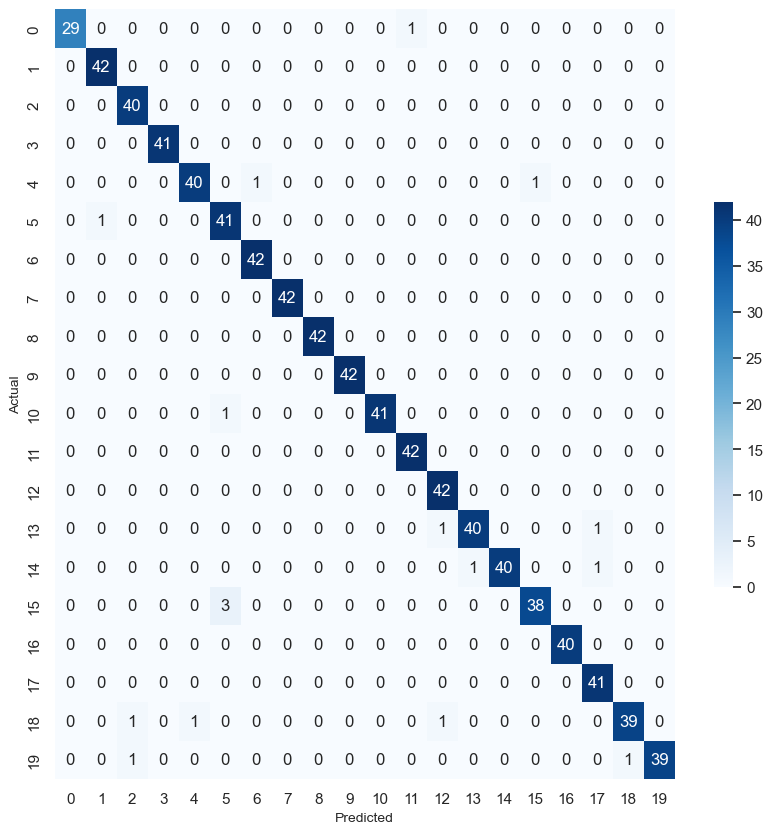

CONFUSION MATRIX ON VALIDATION DATASET 



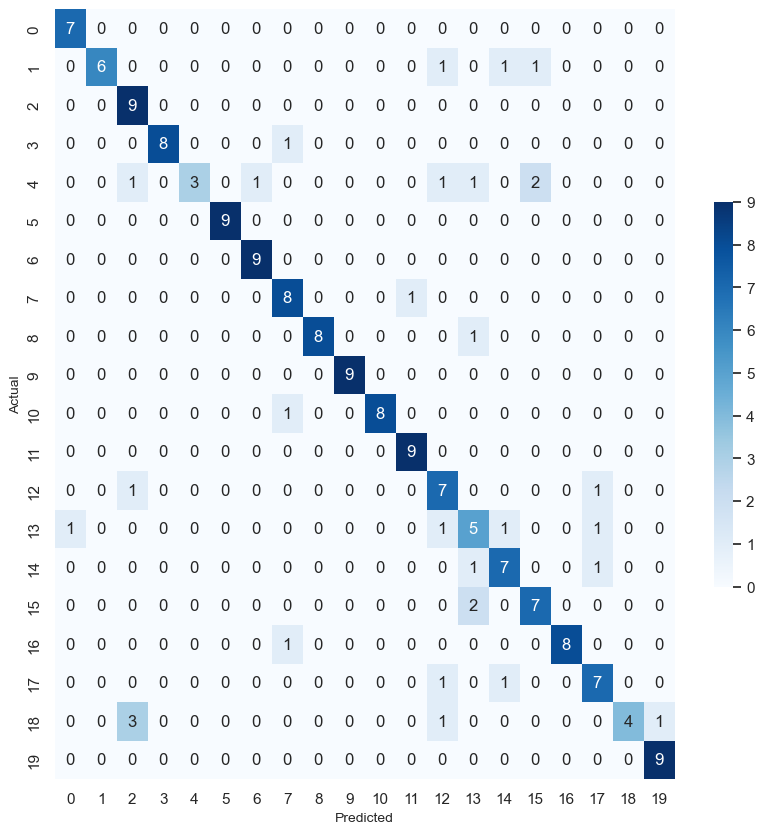

CONFUSION MATRIX ON TEST DATASET 



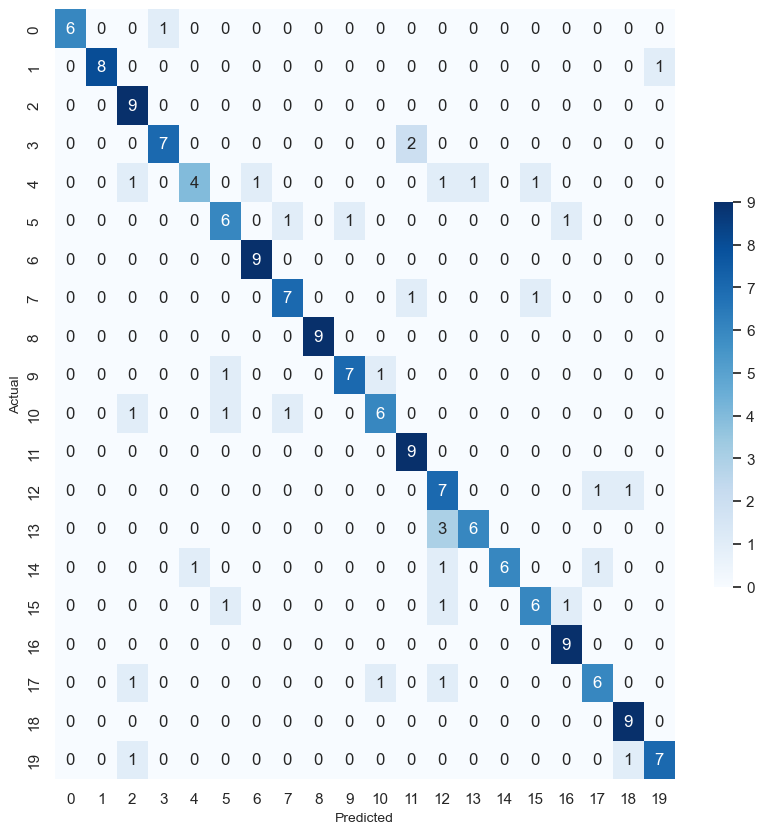

In [19]:
plot_training_vs_validation_metric(effnet_history, 'loss','loss')
plot_training_vs_validation_metric(effnet_history, 'accuracy','accuracy')
plot_training_vs_validation_metric(effnet_history, 'accuracy','error')
effnet_metrics = display_metrics(effnet_model,X_scaled_train, y_scaled_train,X_scaled_validation, y_scaled_validation, X_scaled_test, y_scaled_test)


### Transfer learning with EfficientNetB0 with Early Stopping

In [20]:
effnet_model_early_stopping = build_effNet_model(NUM_CLASSES)
effnet_model_early_stopping.summary()
effnet_history_early_stopping = effnet_model_early_stopping.fit(datagenTrain.flow(X_scaled_train,y_scaled_train.astype('float32')),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=(X_scaled_validation,y_scaled_validation.astype('float32')),
                            callbacks=[checkpoint_efficientNet, early_stop],
                            verbose=1)


Model: "EfficientNetB0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

Epoch 10/100
26/26 [==============================] - ETA: 0s - loss: 1.4296 - accuracy: 0.7659
Epoch 10: val_loss did not improve from 1.37240
26/26 [==============================] - 43s 2s/step - loss: 1.4296 - accuracy: 0.7659 - val_loss: 1.4854 - val_accuracy: 0.8090
Epoch 11/100
26/26 [==============================] - ETA: 0s - loss: 1.3612 - accuracy: 0.7634
Epoch 11: val_loss did not improve from 1.37240
26/26 [==============================] - 51s 2s/step - loss: 1.3612 - accuracy: 0.7634 - val_loss: 1.5416 - val_accuracy: 0.8090
Epoch 12/100
26/26 [==============================] - ETA: 0s - loss: 1.2031 - accuracy: 0.7915
Epoch 12: val_loss did not improve from 1.37240
26/26 [==============================] - 47s 2s/step - loss: 1.2031 - accuracy: 0.7915 - val_loss: 1.5031 - val_accuracy: 0.7472


Below are the results of performing transfer learnig with EfficientNetB0 with early stopping. I have plotted three graphs, 
a. Training Loss vs Validation Loss
b. Training Accuracy vs Validation Accuracy
c. Training Error vs Validation Error

Plot (c) depicts the plot that we want to analyse over the epochs, it can be seen that validation error started off to be lower than training error but then started to increase and varying about over 100 epochs. In order to avoid overfitting we have used early stopping with a patience level of 10, hence at the 19th epoch we could see that there was not significant improvement in the validation loss due which the training stopped. 

Below is also listed the classification report with precision, recall and F1 scores for training, validation and test data set. 
The classification report for training and validation will report the overfit values as this is the dataset over which the model was trained, and would not give us the true picture of how the model actually works. 
Hence looking at how it performs on test set gives us a good picture of how the model is working on unseen data, it can be seen that with early stopping , an accuracy of 0.8033 (80.3%) is achieved. 

Confusion matrix are also plotted for all the three datasets.

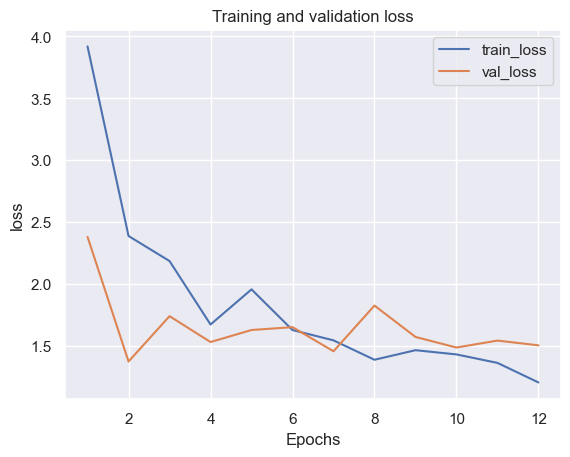

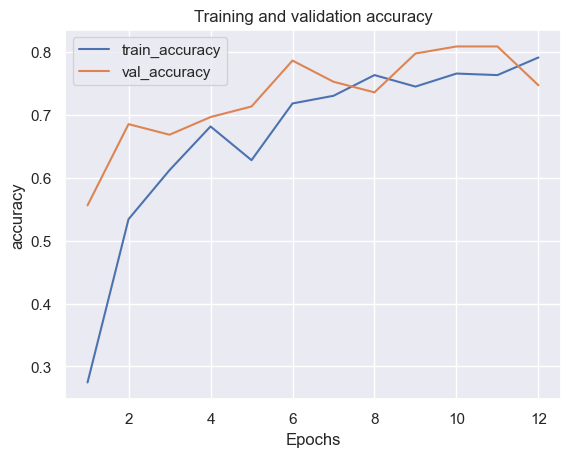

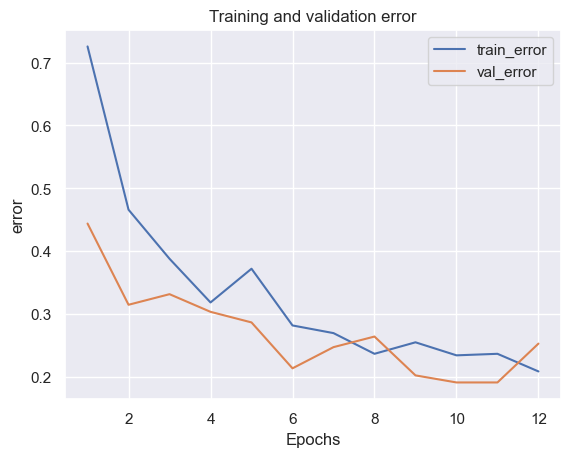

6/6 [==============================] - 3s 552ms/step
ACCURACY ON TRAIN:  0.7536585365853659
ACCURACY ON VALIDATION:  0.6853932584269663
ACCURACY ON TEST:  0.6179775280898876
CLASSIFICATION REPORT ON TRAIN
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.90      0.88      0.89        42
           2       0.97      0.78      0.86        40
           3       0.85      0.83      0.84        41
           4       0.60      0.81      0.69        42
           5       0.67      0.69      0.68        42
           6       0.83      0.93      0.88        42
           7       0.83      0.81      0.82        42
           8       0.63      0.88      0.73        42
           9       0.93      0.88      0.90        42
          10       1.00      0.79      0.88        42
          11       0.87      0.93      0.90        42
          12       0.50      0.48      0.49        42
          13       0.46      0.88     

/Users/keerthanaprakash/opt/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


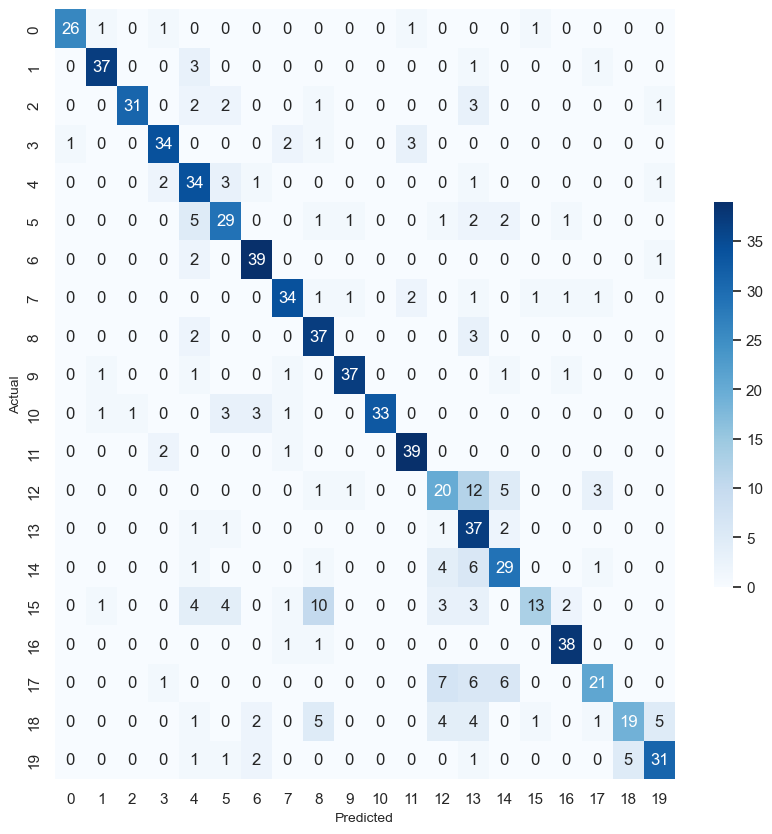

CONFUSION MATRIX ON VALIDATION DATASET 



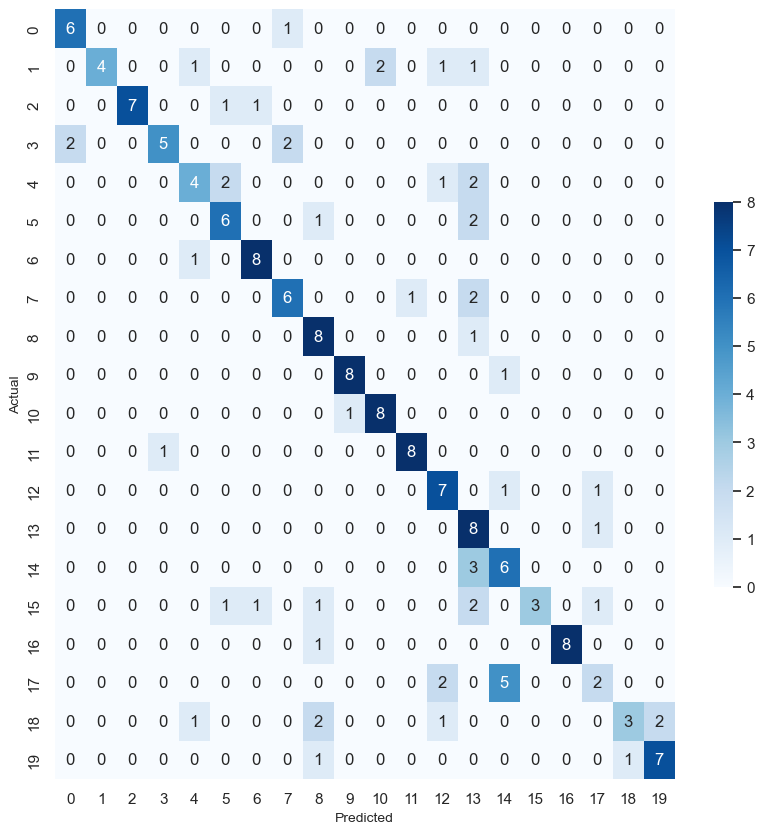

CONFUSION MATRIX ON TEST DATASET 



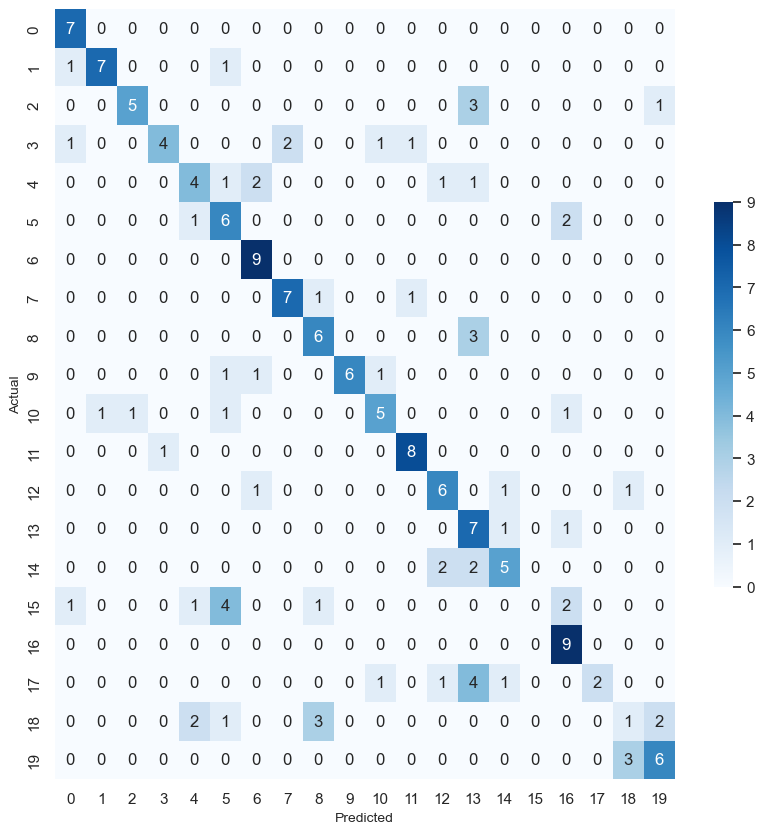

/Users/keerthanaprakash/opt/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
plot_training_vs_validation_metric(effnet_history_early_stopping, 'loss','loss')
plot_training_vs_validation_metric(effnet_history_early_stopping, 'accuracy','accuracy')
plot_training_vs_validation_metric(effnet_history_early_stopping, 'accuracy','error')
effnet_early_stopping_metrics = display_metrics(effnet_model_early_stopping,X_scaled_train, y_scaled_train,X_scaled_validation, y_scaled_validation, X_scaled_test, y_scaled_test)

In [22]:
print("The reported Precision, Recall and F1 scores are macro averages over 20 classes")
print("*********************************************************************************")
print("TRAINING DATA SUMMARY")
train_summary = {
    'Type':["VGG16 without early stopping","VGG16 with early stopping","EfficientNetB0 without early stopping","EfficientNetB0 with early stopping"],
    'Accuracy' :[vgg16_metrics[0][0],vgg16_early_stopping_metrics[0][0],effnet_metrics[0][0],effnet_early_stopping_metrics[0][0]],
    'Precision':[vgg16_metrics[0][1],vgg16_early_stopping_metrics[0][1],effnet_metrics[0][1],effnet_early_stopping_metrics[0][1]],
    'Recall':[vgg16_metrics[0][2],vgg16_early_stopping_metrics[0][2],effnet_metrics[0][2],effnet_early_stopping_metrics[0][2]],
    'F1 Score':[vgg16_metrics[0][3],vgg16_early_stopping_metrics[0][3],effnet_metrics[0][3],effnet_early_stopping_metrics[0][3]]
              }
display(pd.DataFrame(train_summary))
print("*********************************************************************************")

print("VALIDATION DATA SUMMARY")
validation_summary = {
    'Type':["VGG16 without early stopping","VGG16 with early stopping","EfficientNetB0 without early stopping","EfficientNetB0 with early stopping"],
    'Accuracy' :[vgg16_metrics[1][0],vgg16_early_stopping_metrics[1][0],effnet_metrics[1][0],effnet_early_stopping_metrics[1][0]],
    'Precision':[vgg16_metrics[1][1],vgg16_early_stopping_metrics[1][1],effnet_metrics[1][1],effnet_early_stopping_metrics[1][1]],
    'Recall':[vgg16_metrics[1][2],vgg16_early_stopping_metrics[1][2],effnet_metrics[1][2],effnet_early_stopping_metrics[1][2]],
    'F1 Score':[vgg16_metrics[1][3],vgg16_early_stopping_metrics[1][3],effnet_metrics[1][3],effnet_early_stopping_metrics[1][3]]
              }
display(pd.DataFrame(validation_summary))
print("*********************************************************************************")

print("TEST DATA SUMMARY")
test_summary = {
    'Type':["VGG16 without early stopping","VGG16 with early stopping","EfficientNetB0 without early stopping","EfficientNetB0 with early stopping"],
    'Accuracy' :[vgg16_metrics[2][0],vgg16_early_stopping_metrics[2][0],effnet_metrics[2][0],effnet_early_stopping_metrics[2][0]],
    'Precision':[vgg16_metrics[2][1],vgg16_early_stopping_metrics[2][1],effnet_metrics[2][1],effnet_early_stopping_metrics[2][1]],
    'Recall':[vgg16_metrics[2][2],vgg16_early_stopping_metrics[2][2],effnet_metrics[2][2],effnet_early_stopping_metrics[2][2]],
    'F1 Score':[vgg16_metrics[2][3],vgg16_early_stopping_metrics[2][3],effnet_metrics[2][3],effnet_early_stopping_metrics[2][3]]
              }
display(pd.DataFrame(test_summary))
print("*********************************************************************************")

The reported Precision, Recall and F1 scores are macro averages over 20 classes
*********************************************************************************
TRAINING DATA SUMMARY


,Type,Accuracy,Precision,Recall,F1 Score
0,VGG16 without early stopping,0.975610,0.978804,0.975753,0.976039
1,VGG16 with early stopping,0.971951,0.974466,0.971969,0.972385
2,EfficientNetB0 without early stopping,0.979268,0.980117,0.979141,0.979316
3,EfficientNetB0 with early stopping,0.753659,0.783630,0.755077,0.753666


*********************************************************************************
VALIDATION DATA SUMMARY


,Type,Accuracy,Precision,Recall,F1 Score
0,VGG16 without early stopping,0.747191,0.778222,0.748413,0.744312
1,VGG16 with early stopping,0.792135,0.820366,0.792857,0.790073
2,EfficientNetB0 without early stopping,0.825843,0.856423,0.827778,0.822082
3,EfficientNetB0 with early stopping,0.685393,0.736212,0.687302,0.681230


*********************************************************************************
TEST DATA SUMMARY


,Type,Accuracy,Precision,Recall,F1 Score
0,VGG16 without early stopping,0.730337,0.758953,0.726984,0.724015
1,VGG16 with early stopping,0.769663,0.806690,0.767460,0.770152
2,EfficientNetB0 without early stopping,0.803371,0.822763,0.803968,0.802488
3,EfficientNetB0 with early stopping,0.617978,0.629527,0.622222,0.595389


*********************************************************************************


### References: 
1. https://towardsdatascience.com/cifar-100-transfer-learning-using-efficientnet-ed3ed7b89af2
2. https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf
3. https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
4. https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
5. https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf
6. https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400
7. https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
8. https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5
9. https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e
10. https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
11. https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

### Extra Practice

In [23]:
X_augmented_train = X_scaled_train
y_augmented_train = y_scaled_train

In [24]:
def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
        
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img

def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def zoom(img, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img


In [25]:
for img in range(len(X_scaled_train)):
    augmented_image_list = []
    augmented_label_list = []
    
    label = y_scaled_train[img]
    image = X_scaled_train[img]
    
    #horizontal_shift
    img_h = horizontal_shift(X_scaled_train[2], 0.7)
    augmented_image_list.append(img_h)
    augmented_label_list.append(label)
    
    #vertical_shift
    img_v = vertical_shift(X_scaled_train[2], 0.7)
    augmented_image_list.append(img_v)
    augmented_label_list.append(label)
    
    #contrast
    img_b = brightness(X_scaled_train[2], 0.5, 3)
    augmented_image_list.append(img_b)
    augmented_label_list.append(label)
    
    #zoom
    img_z = zoom(X_scaled_train[2], 0.5)
    augmented_image_list.append(img_z)
    augmented_label_list.append(label)
    
    #flip
    img_hf = horizontal_flip(X_scaled_train[2], True)
    augmented_image_list.append(img_hf)
    augmented_label_list.append(label)
    
    #flip2
    img_vf = vertical_flip(X_scaled_train[2], True)
    augmented_image_list.append(img_vf)
    augmented_label_list.append(label)
    
    #rotate
    img_r = rotation(X_scaled_train[2], 30) 
    augmented_image_list.append(img_r)
    augmented_label_list.append(label)

    
    X_augmented_train = np.concatenate((X_augmented_train, np.array(augmented_image_list)), axis=0)
    y_augmented_train = np.concatenate((y_augmented_train,np.array(augmented_label_list)),axis=0)

In [ ]:
vgg16_model_opencv = build_vgg16_model(NUM_CLASSES)
vgg16_model_opencv.summary()


vgg16_history_opencv = vgg16_model_opencv.fit(x=X_augmented_train,y=y_augmented_train.astype('float32'),
                            batch_size=BATCH_SIZE,
                            epochs=50,
                            validation_data=(X_scaled_validation,y_scaled_validation.astype('float32')),
                            verbose=1)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     